#Deep Reinforcement Learning Networks:
Deep Reinforcement Learning (DRL) networks combine deep neural networks with reinforcement learning algorithms. These networks learn to make decisions by interacting with an environment and receiving feedback (rewards or penalties) based on their actions. DRL has been successfully applied to tasks like game playing (e.g., AlphaGo), robotic control, and resource management.

#Deep Q-Network (DQN)

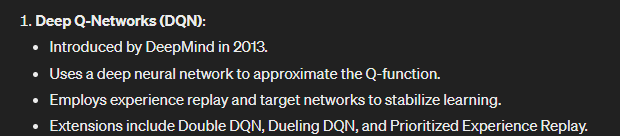

In [ ]:
import tensorflow as tf
import numpy as np
import gym

# Define the Deep Q-Network (DQN) class
class DQNAgent:
    def __init__(self, state_dim, action_dim, learning_rate=0.001, gamma=0.99):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.learning_rate = learning_rate
        self.gamma = gamma

        # Define the neural network model
        self.model = self.build_model()

        # Define the optimizer and loss function
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.loss_function = tf.keras.losses.MeanSquaredError()

    def build_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(32, activation='relu', input_shape=(self.state_dim,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(self.action_dim, activation='linear')
        ])
        return model

    def choose_action(self, state, epsilon=0.1):
        # Epsilon-greedy policy to choose actions
        if np.random.uniform() < epsilon:
            return np.random.choice(self.action_dim)
        else:
            state = np.expand_dims(state, axis=0)
            q_values = self.model.predict(state)
            return np.argmax(q_values)

    def train(self, state_batch, action_batch, reward_batch, next_state_batch, done_batch, batch_size=32):
        # Convert batches to TensorFlow tensors
        state_batch = tf.convert_to_tensor(state_batch, dtype=tf.float32)
        action_batch = tf.convert_to_tensor(action_batch, dtype=tf.int32)
        reward_batch = tf.convert_to_tensor(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(next_state_batch, dtype=tf.float32)
        done_batch = tf.convert_to_tensor(done_batch, dtype=tf.float32)

        # Compute Q-values for the current state and next state
        with tf.GradientTape() as tape:
            q_values = self.model(state_batch)
            q_values_next = self.model(next_state_batch)
            target_q_values = reward_batch + self.gamma * tf.reduce_max(q_values_next, axis=1) * (1.0 - done_batch)

            # Gather the predicted Q-values for the selected actions
            action_mask = tf.one_hot(action_batch, self.action_dim)
            predicted_q_values = tf.reduce_sum(tf.multiply(q_values, action_mask), axis=1)

            # Compute loss between predicted Q-values and target Q-values
            loss = self.loss_function(target_q_values, predicted_q_values)

        # Compute gradients and update the model
        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

In [ ]:
# Example usage with OpenAI Gym
env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

agent = DQNAgent(state_dim, action_dim)

num_episodes = 100
for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False

    while not done:
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.train(np.array([state]), np.array([action]), np.array([reward]), np.array([next_state]), np.array([done]))
        total_reward += reward
        state = next_state

    print(f"Episode {episode + 1}, Total Reward: {total_reward}")

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


1/1 [==============================] - 0s 404ms/step


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


1/1 [==============================] - 0s 33ms/step
Episode 1, Total Reward: 9.0
1/1 [==============================] - 0s 18ms/step
Episode 2, Total Reward: 103.0
1/1 [==============================] - 0s 18ms/step
Episode 3, Total Reward: 9.0
1/1 [==============================] - 0s 19ms/step
Episode 4, Total Reward: 13.0
1/1 [==============================] - 0s 18ms/step
Episode 5, Total Reward: 9.0
1/1 [==============================] - 0s 31ms/step
Episode 6, Total Reward: 17.0
1/1 [==============================] - 0s 17ms/step
Episode 7, Total Reward: 102.0
1/1 [==============================] - 0s 18ms/step
Episode 8, Total Reward: 9.0
1/1 [==============================] - 0s 64ms/step
Episode 9, Total Reward: 11.0
1/1 [==============================] - 0s 19ms/step
Episode 10, Total Reward: 10.0
1/1 [==============================] - 0s 37ms/step
Episode 11, Total Reward: 10.0
1/1 [==============================] - 0s 45ms/step
Episode 12, Total Reward: 10.0
1/1 [==========

# Double DQN

In [ ]:
import tensorflow as tf
import numpy as np
import random
from collections import deque
import gym

class DoubleDQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.memory = deque(maxlen=2000)  # Replay memory buffer
        self.build_model()

    def build_model(self):
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(24, input_dim=self.state_size, activation='relu'),
            tf.keras.layers.Dense(24, activation='relu'),
            tf.keras.layers.Dense(self.action_size, activation='linear')
        ])
        self.target_model = tf.keras.models.clone_model(self.model)
        self.model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=self.learning_rate))

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        q_values = self.model.predict(state)
        return np.argmax(q_values[0])

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = self.model.predict(state)
            if done:
                target[0][action] = reward
            else:
                best_action = np.argmax(self.model.predict(next_state)[0])
                Q_future = self.target_model.predict(next_state)[0][best_action]
                target[0][action] = reward + self.gamma * Q_future
            self.model.fit(state, target, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def train(self, env, episodes, batch_size):
        for episode in range(episodes):
            state = env.reset()
            state = np.reshape(state, [1, self.state_size])
            total_reward = 0
            done = False
            while not done:
                action = self.choose_action(state)
                next_state, reward, done, _ = env.step(action)
                next_state = np.reshape(next_state, [1, self.state_size])
                self.remember(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward
            self.replay(batch_size)
            self.update_target_model()
            print(f"Episode: {episode + 1}, Total Reward: {total_reward}")

    def save(self, path):
        self.model.save_weights(path)

    def load(self, path):
        self.model.load_weights(path)
        self.target_model.set_weights(self.model.get_weights())

# Main function
if __name__ == "__main__":
    # Initialize OpenAI Gym environment
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    # Initialize Double DQN agent
    agent = DoubleDQNAgent(state_size, action_size)

    # Train the agent
    episodes = 100
    batch_size = 32
    agent.train(env, episodes, batch_size)

    # Save trained model
    agent.save("double_dqn_cartpole.h5")

Se han truncado las últimas 5000 líneas del flujo de salida.
1/1 [==============================] - 0s 26ms/step
Episode: 50, Total Reward: 12.0
1/1 [==============================] - 0s 26ms/step
Episode: 51, Total Reward: 23.0
1/1 [==============================] - 0s 19ms/step
Episode: 52, Total Reward: 74.0
1/1 [==============================] - 0s 27ms/step
Episode: 53, Total Reward: 15.0
1/1 [==============================] - 0s 25ms/step
Episode: 54, Total Reward: 9.0
1/1 [==============================] - 0s 37ms/step
Episode: 55, Total Reward: 14.0
1/1 [==============================] - 0s 27ms/step
Episode: 56, Total Reward: 14.0
1/1 [==============================] - 0s 31ms/step
Episode: 57, Total Reward: 14.0
1/1 [==============================] - 0s 26ms/step
Episode: 58, Total Reward: 13.0
1/1 [==============================] - 0s 26ms/step
Episode: 59, Total Reward: 16.0
1/1 [==============================] - 0s 26ms/step
Episode: 60, Total Reward: 30.0
1/1 [===========

#Dueling DQN

In [ ]:
import tensorflow as tf
import numpy as np
import random
from collections import deque
import gym

class DuelingDQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.memory = deque(maxlen=2000)  # Replay memory buffer
        self.build_model()

    def build_model(self):
        input_layer = tf.keras.layers.Input(shape=(self.state_size,))
        dense1 = tf.keras.layers.Dense(24, activation='relu')(input_layer)
        dense2 = tf.keras.layers.Dense(24, activation='relu')(dense1)

        # Split into value and advantage streams
        value_stream = tf.keras.layers.Dense(1)(dense2)
        advantage_stream = tf.keras.layers.Dense(self.action_size)(dense2)

        # Combine value and advantage streams to get Q-values
        combined_stream = tf.keras.layers.Add()([value_stream, tf.keras.layers.Subtract()([advantage_stream, tf.keras.backend.mean(advantage_stream, axis=1, keepdims=True)])])

        self.model = tf.keras.models.Model(inputs=input_layer, outputs=combined_stream)
        self.model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=self.learning_rate))

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        q_values = self.model.predict(state)
        return np.argmax(q_values[0])

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = self.model.predict(state)
            if done:
                target[0][action] = reward
            else:
                next_q_values = self.model.predict(next_state)
                target[0][action] = reward + self.gamma * np.amax(next_q_values)
            self.model.fit(state, target, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def train(self, env, episodes, batch_size):
        for episode in range(episodes):
            state = env.reset()
            state = np.reshape(state, [1, self.state_size])
            total_reward = 0
            done = False
            while not done:
                action = self.choose_action(state)
                next_state, reward, done, _ = env.step(action)
                next_state = np.reshape(next_state, [1, self.state_size])
                self.remember(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward
            self.replay(batch_size)
            print(f"Episode: {episode + 1}, Total Reward: {total_reward}")

    def save(self, path):
        self.model.save_weights(path)

    def load(self, path):
        self.model.load_weights(path)

# Main function
if __name__ == "__main__":
    # Initialize OpenAI Gym environment
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    # Initialize Dueling DQN agent
    agent = DuelingDQNAgent(state_size, action_size)

    # Train the agent
    episodes = 10
    batch_size = 32
    agent.train(env, episodes, batch_size)

    # Save trained model
    agent.save("dueling_dqn_cartpole.h5")

Episode: 1, Total Reward: 13.0
Episode: 2, Total Reward: 17.0
1/1 [==============================] - 0s 69ms/step
Episode: 3, Total Reward: 16.0
1/1 [==============================] - 0s 18ms/step
Episode: 4, Total Reward: 12.0
1/1 [==============================] - 0s 18ms/step
Episode: 5, Total Reward: 20.0
1/1 [==============================] - 0s 31ms/step
Episode: 6, Total Reward: 24.0
1/1 [==============================] - 0s 19ms/step
Episode: 7, Total Reward: 15.0
1/1 [==============================] - 0s 19ms/step
Episode: 8, Total Reward: 37.0
1/1 [==============================] - 0s 20ms/step
Episode: 9, Total Reward: 21.0
1/1 [==============================] - 0s 21ms/step
Episode: 10, Total Reward: 35.0


#Prioritized Experience Replay

In [ ]:
import tensorflow as tf
import numpy as np
import random
from collections import deque
import gym
class PrioritizedDuelingDQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, alpha=0.6, beta=0.4, beta_increment_per_sampling=0.001, absolute_error_upper=1.0):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.alpha = alpha  # Prioritization parameter
        self.beta = beta  # Importance-sampling weight parameter
        self.beta_increment_per_sampling = beta_increment_per_sampling
        self.absolute_error_upper = absolute_error_upper
        self.memory = PrioritizedReplayBuffer(maxlen=2000)
        self.build_model()

    def build_model(self):
        input_layer = tf.keras.layers.Input(shape=(self.state_size,))
        dense1 = tf.keras.layers.Dense(24, activation='relu')(input_layer)
        dense2 = tf.keras.layers.Dense(24, activation='relu')(dense1)

        # Split into value and advantage streams
        value_stream = tf.keras.layers.Dense(1)(dense2)
        advantage_stream = tf.keras.layers.Dense(self.action_size)(dense2)

        # Combine value and advantage streams to get Q-values
        combined_stream = tf.keras.layers.Add()([value_stream, tf.keras.layers.Subtract()([advantage_stream, tf.keras.backend.mean(advantage_stream, axis=1, keepdims=True)])])

        self.model = tf.keras.models.Model(inputs=input_layer, outputs=combined_stream)
        self.model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=self.learning_rate))

    def remember(self, state, action, reward, next_state, done):
        max_priority = np.max(self.memory.priority) if self.memory.tree else 1.0
        self.memory.add(max_priority, (state, action, reward, next_state, done))

    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        q_values = self.model.predict(state)
        return np.argmax(q_values[0])

    def replay(self, batch_size):
        tree_idx, minibatch, is_weight = self.memory.sample(batch_size, self.beta)
        states = []
        targets = []
        for idx, (state, action, reward, next_state, done) in enumerate(minibatch):
            target = self.model.predict(state)
            if done:
                target[0][action] = reward
            else:
                next_q_values = self.model.predict(next_state)
                target[0][action] = reward + self.gamma * np.amax(next_q_values)
            states.append(state[0])
            targets.append(target[0])

        states = np.array(states)
        targets = np.array(targets)

        # Update model with calculated targets
        self.model.fit(states, targets, epochs=1, verbose=0, sample_weight=is_weight)

        # Update priorities in the replay buffer
        td_errors = np.abs(targets - self.model.predict(states))
        for i in range(batch_size):
            idx = tree_idx[i]
            self.memory.update(idx, td_errors[i][0] + 1e-6)  # Add small constant to avoid zero priority

        # Increase beta for importance-sampling weight
        self.beta = np.min([1.0, self.beta + self.beta_increment_per_sampling])

    def train(self, env, episodes, batch_size):
        for episode in range(episodes):
            state = env.reset()
            state = np.reshape(state, [1, self.state_size])
            total_reward = 0
            done = False
            while not done:
                action = self.choose_action(state)
                next_state, reward, done, _ = env.step(action)
                next_state = np.reshape(next_state, [1, self.state_size])
                self.remember(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward
            self.replay(batch_size)
            print(f"Episode: {episode + 1}, Total Reward: {total_reward}")

    def save(self, path):
        self.model.save_weights(path)

    def load(self, path):
        self.model.load_weights(path)

class PrioritizedReplayBuffer:
    def __init__(self, maxlen):
        self.maxlen = maxlen
        self.tree = SumTree(maxlen)
        self.priority = 1.0

    def add(self, priority, data):
        self.tree.add(priority, data)

    def sample(self, batch_size, beta):
        batch = []
        tree_idx = np.zeros(batch_size, dtype=np.int32)
        is_weight = np.zeros(batch_size)
        segment = self.tree.total() / batch_size
        priorities = []

        for i in range(batch_size):
            a = segment * i
            b = segment * (i + 1)
            s = random.uniform(a, b)
            idx, priority, data = self.tree.get(s)
            batch.append(data)
            tree_idx[i] = idx
            priorities.append(priority)

        priorities = np.array(priorities)
        sampling_probabilities = priorities / self.tree.total()
        is_weight = np.power(self.tree.n_entries * sampling_probabilities, -beta)
        is_weight /= is_weight.max()

        return tree_idx, batch, is_weight

    def update(self, idx, priority):
        self.tree.update(idx, priority)

class SumTree:
    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype=object)
        self.n_entries = 0

    def add(self, priority, data):
        idx = self.n_entries + self.capacity - 1
        self.data[self.n_entries] = data
        self.update(idx, priority)
        self.n_entries += 1
        if self.n_entries >= self.capacity:
            self.n_entries = self.capacity

    def update(self, idx, priority):
        change = priority - self.tree[idx]
        self.tree[idx] = priority
        while idx != 0:
            idx = (idx - 1) // 2
            self.tree[idx] += change

    def get(self, s):
        idx = 0
        while True:
            left = 2 * idx + 1
            right = left + 1
            if left >= len(self.tree):
                break
            if s <= self.tree[left]:
                idx = left
            else:
                s -= self.tree[left]
                idx = right
        data_idx = idx - self.capacity + 1
        return idx, self.tree[idx], self.data[data_idx]

    def total(self):
        return self.tree[0]

# Main function
if __name__ == "__main__":
    # Initialize OpenAI Gym environment
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    # Initialize Prioritized Dueling DQN agent
    agent = PrioritizedDuelingDQNAgent(state_size, action_size)

    # Train the agent
    episodes = 10
    batch_size = 32
    agent.train(env, episodes, batch_size)

    # Save trained model
    agent.save("prioritized_dueling_dqn_cartpole.h5")

1/1 [==============================] - 0s 17ms/step
Episode: 1, Total Reward: 11.0
1/1 [==============================] - 0s 17ms/step
Episode: 2, Total Reward: 27.0
1/1 [==============================] - 0s 19ms/step
Episode: 3, Total Reward: 22.0
1/1 [==============================] - 0s 27ms/step
Episode: 4, Total Reward: 34.0
1/1 [==============================] - 0s 19ms/step
Episode: 5, Total Reward: 30.0
1/1 [==============================] - 0s 19ms/step
Episode: 6, Total Reward: 17.0
1/1 [==============================] - 0s 21ms/step
Episode: 7, Total Reward: 13.0
1/1 [==============================] - 0s 19ms/step
Episode: 8, Total Reward: 16.0
1/1 [==============================] - 0s 17ms/step
Episode: 9, Total Reward: 29.0
1/1 [==============================] - 0s 21ms/step
Episode: 10, Total Reward: 40.0
